In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('DATA/Sample-Superstore.xls', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
sales = np.array(df['Sales']).reshape((-1, 1))
sales = scaler.fit_transform(sales)

dates = df['Order Date'].sort_values()
dates[:100]

7980   2014-01-03
739    2014-01-04
740    2014-01-04
741    2014-01-04
1759   2014-01-05
          ...    
9259   2014-02-11
9254   2014-02-11
9255   2014-02-11
9256   2014-02-11
9257   2014-02-11
Name: Order Date, Length: 100, dtype: datetime64[ns]

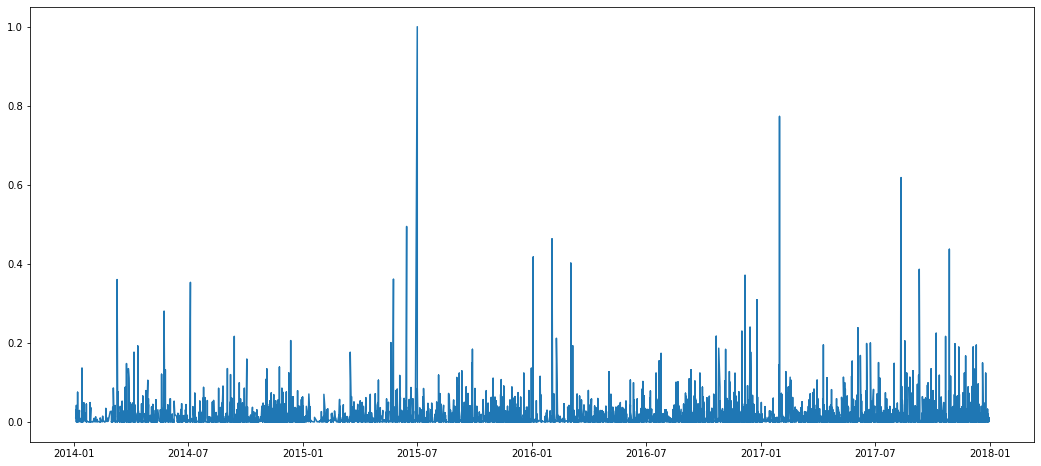

In [6]:
plt.figure(figsize=(18, 8))
plt.plot(dates, sales)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    print(dataset)    
    return dataset

In [8]:
train_data = windowed_dataset(sales, 30, 30, 30)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_data, epochs=130, callbacks=[lr_schedule])

Epoch 1/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0123 - mae: 0.1161 - lr: 1.0000e-08
Epoch 2/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0122 - mae: 0.1151 - lr: 1.1220e-08
Epoch 3/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0120 - mae: 0.1140 - lr: 1.2589e-08
Epoch 4/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0119 - mae: 0.1128 - lr: 1.4125e-08
Epoch 5/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0117 - mae: 0.1115 - lr: 1.5849e-08
Epoch 6/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0115 - mae: 0.1102 - lr: 1.7783e-08
Epoch 7/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0114 - mae: 0.1089 - lr: 1.9953e-08
Epoch 8/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0112 - mae: 0.1075 - lr: 2.2387e-08
Epoch 9/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0110 - mae: 0.1061 

Epoch 73/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0013 - mae: 0.0310 - lr: 3.9811e-05
Epoch 74/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0012 - mae: 0.0300 - lr: 4.4668e-05
Epoch 75/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0012 - mae: 0.0290 - lr: 5.0119e-05
Epoch 76/130
333/333 [==============================] - 3s 8ms/step - loss: 0.0011 - mae: 0.0281 - lr: 5.6234e-05
Epoch 77/130
333/333 [==============================] - 3s 10ms/step - loss: 0.0011 - mae: 0.0272 - lr: 6.3096e-05
Epoch 78/130
333/333 [==============================] - 3s 10ms/step - loss: 0.0010 - mae: 0.0264 - lr: 7.0795e-05
Epoch 79/130
333/333 [==============================] - 3s 9ms/step - loss: 9.5922e-04 - mae: 0.0256 - lr: 7.9433e-05
Epoch 80/130
333/333 [==============================] - 3s 9ms/step - loss: 9.1593e-04 - mae: 0.0248 - lr: 8.9125e-05
Epoch 81/130
333/333 [==============================] - 3s 10ms/step - loss: 8

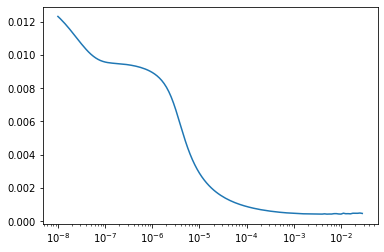

In [11]:
plt.semilogx(history.history["lr"], history.history['loss'])

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=['mae'])
history = model.fit(train_data, epochs = 100)

Epoch 1/100
333/333 [==============================] - 3s 8ms/step - loss: 0.0040 - mae: 0.0575
Epoch 2/100
333/333 [==============================] - 3s 8ms/step - loss: 0.0017 - mae: 0.0369
Epoch 3/100
333/333 [==============================] - 3s 8ms/step - loss: 0.0013 - mae: 0.0315
Epoch 4/100
333/333 [==============================] - 3s 8ms/step - loss: 0.0011 - mae: 0.0286
Epoch 5/100
333/333 [==============================] - 3s 8ms/step - loss: 9.8023e-04 - mae: 0.0267
Epoch 6/100
333/333 [==============================] - 3s 8ms/step - loss: 9.0200e-04 - mae: 0.0254
Epoch 7/100
333/333 [==============================] - 3s 8ms/step - loss: 8.4727e-04 - mae: 0.0244
Epoch 8/100
333/333 [==============================] - 3s 8ms/step - loss: 8.0474e-04 - mae: 0.0235
Epoch 9/100
333/333 [==============================] - 3s 8ms/step - loss: 7.7129e-04 - mae: 0.0229
Epoch 10/100
333/333 [==============================] - 3s 8ms/step - loss: 7.4527e-04 - mae: 0.0223
Epoch 11/100
33

333/333 [==============================] - 3s 8ms/step - loss: 4.7102e-04 - mae: 0.0151
Epoch 83/100
333/333 [==============================] - 3s 8ms/step - loss: 4.7035e-04 - mae: 0.0151
Epoch 84/100
333/333 [==============================] - 3s 8ms/step - loss: 4.6973e-04 - mae: 0.0151
Epoch 85/100
333/333 [==============================] - 3s 8ms/step - loss: 4.6888e-04 - mae: 0.0150
Epoch 86/100
333/333 [==============================] - 3s 8ms/step - loss: 4.6802e-04 - mae: 0.0150
Epoch 87/100
333/333 [==============================] - 3s 8ms/step - loss: 4.6713e-04 - mae: 0.0150
Epoch 88/100
333/333 [==============================] - 2s 7ms/step - loss: 4.6632e-04 - mae: 0.0149
Epoch 89/100
333/333 [==============================] - 2s 7ms/step - loss: 4.6581e-04 - mae: 0.0149
Epoch 90/100
333/333 [==============================] - 2s 7ms/step - loss: 4.6521e-04 - mae: 0.0149
Epoch 91/100
333/333 [==============================] - 2s 7ms/step - loss: 4.6440e-04 - mae: 0.0149
Epo

In [13]:
forecast = []
test_data = sales[:300]
for time in range(len(test_data)):
    forecast.append(model.predict(test_data[time:time + 30][np.newaxis]))

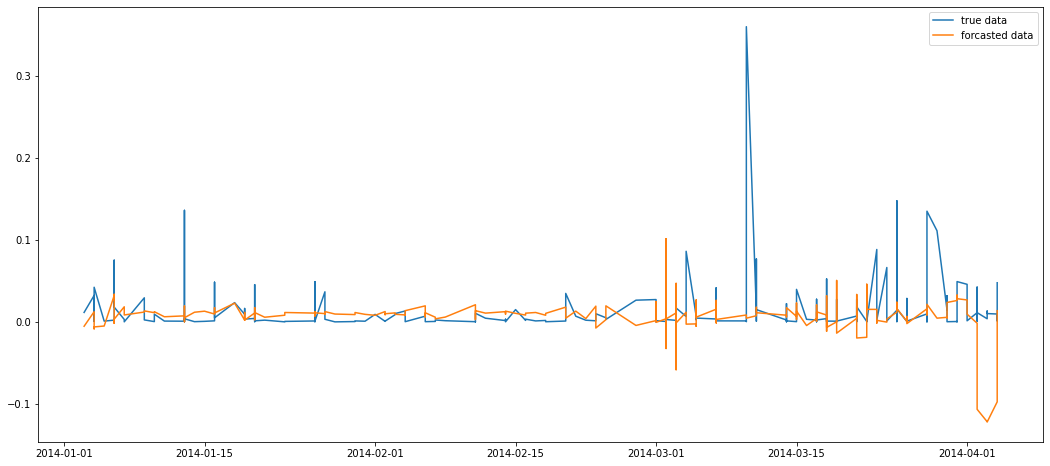

In [14]:
plt.figure(figsize=(18, 8))
plt.plot(dates[:300], test_data, label="true data")
plt.plot(dates[:300], np.array(forecast).reshape((300,)), label="forcasted data")
plt.legend()

In [15]:
forecast

[array([[-0.00532471]], dtype=float32),
 array([[0.01241295]], dtype=float32),
 array([[-0.00848529]], dtype=float32),
 array([[-0.00613078]], dtype=float32),
 array([[-0.00505067]], dtype=float32),
 array([[0.0322059]], dtype=float32),
 array([[0.03373239]], dtype=float32),
 array([[0.00168925]], dtype=float32),
 array([[0.01472586]], dtype=float32),
 array([[0.01312465]], dtype=float32),
 array([[-0.001788]], dtype=float32),
 array([[0.00372133]], dtype=float32),
 array([[0.00151669]], dtype=float32),
 array([[0.0033237]], dtype=float32),
 array([[0.018429]], dtype=float32),
 array([[0.00844345]], dtype=float32),
 array([[0.01203712]], dtype=float32),
 array([[0.01344157]], dtype=float32),
 array([[0.01122606]], dtype=float32),
 array([[0.01244518]], dtype=float32),
 array([[0.00626755]], dtype=float32),
 array([[0.00736006]], dtype=float32),
 array([[0.009689]], dtype=float32),
 array([[0.00841877]], dtype=float32),
 array([[0.00832587]], dtype=float32),
 array([[0.01941173]], dtype

In [16]:
sales[:300]

array([[1.15520622e-02],
       [3.23126971e-02],
       [6.26202732e-04],
       [4.22798824e-02],
       [9.68458571e-04],
       [2.13870143e-03],
       [3.01969658e-04],
       [4.00524144e-02],
       [7.97772386e-04],
       [5.05591563e-03],
       [7.53484092e-02],
       [4.02411234e-02],
       [6.67372382e-04],
       [1.80020917e-02],
       [3.01996163e-03],
       [9.27642310e-05],
       [2.93945994e-02],
       [2.43201310e-03],
       [3.58511666e-04],
       [9.41053367e-03],
       [9.84007623e-04],
       [8.40002198e-04],
       [2.64581256e-03],
       [3.13313399e-03],
       [4.61252911e-02],
       [4.94919259e-04],
       [3.98117575e-03],
       [1.36186107e-01],
       [4.05247169e-04],
       [5.46672865e-03],
       [1.24569110e-04],
       [3.79273184e-03],
       [2.83328465e-04],
       [6.76560458e-04],
       [1.28226671e-03],
       [4.84626847e-02],
       [8.41398079e-03],
       [4.98647498e-03],
       [2.34982929e-02],
       [9.34771903e-03],
